In [37]:
using Pkg
Pkg.activate("./MISAEM")

# Display the status of the current environment
Pkg.status()

Project 

  Activating project at `~/Documents/Code/misaem_julia/MISAEM`


MISAEM v0.1.0
Status `~/Documents/Code/misaem_julia/MISAEM/Project.toml`
  [6e4b80f9] BenchmarkTools v1.6.0
⌃ [31c24e10] Distributions v0.25.120
  [38e38edf] GLM v1.9.0
⌃ [7073ff75] IJulia v1.30.5
  [91a5bcdd] Plots v1.41.1
  [92933f4c] ProgressMeter v1.11.0
  [438e738f] PyCall v1.96.4
  [10745b16] Statistics v1.11.1
  [37e2e46d] LinearAlgebra v1.11.0
  [9a3f8284] Random v1.11.0
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [38]:
using MISAEM
using Random
using Distributions
using LinearAlgebra
using Statistics

# Set a random seed for reproducibility
# Random.seed!(123)

# 2. Generate some example data
# n: number of samples, p: number of features
n = 2000
n_test = 1000
p = 100
prop_na = 0.50

# Create a design matrix X with some missing values (NaN)
X_complete = rand(Normal(), n, p)
X_missing = copy(X_complete)
X_missing[rand(Bool, n, p) .< prop_na] .= NaN

X_missing_fit = copy(X_missing[1:(n - n_test), :])
X_missing_test = copy(X_missing[(n - n_test + 1):end, :])


# Create a response vector y (binary)
true_coeffs = randn(p)
linear_predictor = X_complete[:, 1:p] * true_coeffs
probabilities = 1.0 ./ (1.0 .+ exp.(-linear_predictor))
y = rand.(Bernoulli.(probabilities));

y_fit = y[1:(n - n_test)]
y_test = y[(n - n_test + 1):end]

println(probabilities[1:10])
println(y[1:10])
println(mean(y))

[0.9984987566098646, 0.9989773499112515, 5.168138322718999e-5, 1.7215213991803248e-6, 0.008217170124933532, 0.9999999999998455, 0.9846524968649467, 0.754705388108254, 0.908498769009582, 0.21968677638766423]
Bool[1, 1, 0, 0, 0, 1, 1, 1, 1, 1]
0.496


In [39]:


# 3. Instantiate the MISAEM model
# You can adjust hyperparameters here if needed
model = MISAEM.SAEMLogisticRegression(
    maxruns = 1000,
    random_state = 42,
    var_cal=true,
    ll_obs_cal=false
)


SAEMLogisticRegression(1000, 1.0e-7, 2, 1.0, 50, true, false, nothing, 42, Float64[], 0.0, Float64[], Float64[], Matrix{Float64}(undef, 0, 0), 0.0, false, 0)

In [40]:

# 4. Fit the model to the data
println("Fitting the model...")
MISAEM.fit!(model, X_missing_fit, y_fit)


Fitting the model...


SAEM Iterations: 100%|██████████████████████████████████| Time: 0:00:59


LoadError: ArgumentError: matrix contains Infs or NaNs

In [ ]:

# 5. Display the results
println("\nFitting complete.")
println("Converged: ", model.converged)
println("Number of iterations: ", model.n_iterations)
println("Estimated Coefficients (including intercept):")
println(model.coef)
println("Observed Log-Likelihood: ", model.ll_obs)

# 6. Make predictions on the training data
println("\nMaking predictions...")
predictions = MISAEM.predict(model, X_missing_test, method=:map)
probabilities = MISAEM.predict_proba(model, X_missing_test, method=:map)

println("Prediction for the first 5 samples: ", predictions[1:5])
println("Probabilities for the first 5 samples: ", probabilities[1:5, 2])


Fitting complete.
Converged: true
Number of iterations: 101
Estimated Coefficients (including intercept):
[-0.0020489632974208657, 0.7130389145243202, -1.6620069845977912, -0.4004421987371219]
Observed Log-Likelihood: 0.0

Making predictions...
Prediction for the first 5 samples: 

┌ Warning: 119 rows with all NaN values in X have been removed.
└ @ MISAEM ~/Documents/Code/misaem_julia/MISAEM/src/MISAEM.jl:116
┌ Warning: 119 rows with all NaN values in X have been removed.
└ @ MISAEM ~/Documents/Code/misaem_julia/MISAEM/src/MISAEM.jl:116


[0, 1, 0, 0, 0]
Probabilities for the first 5 samples: [0.31104227918112454, 0.5794889357943152, 0.46073447990969835, 0.33518411208073784, 0.209996353066374]


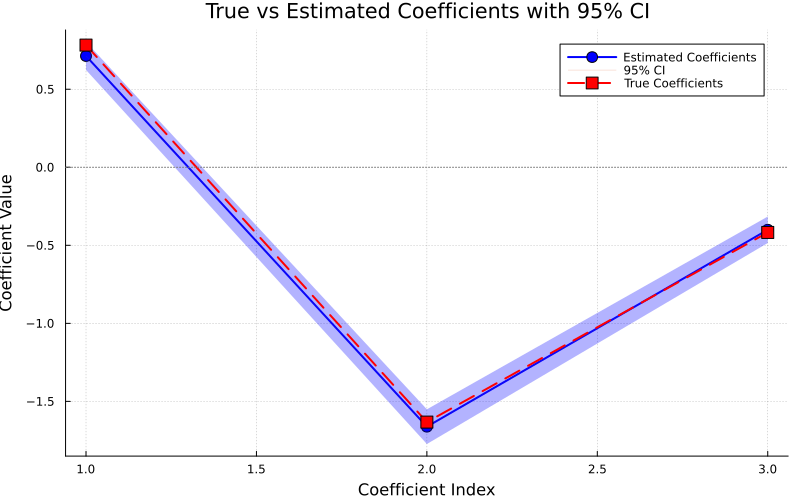


Coefficient Comparison Summary
Index | True Coef | Estimated | Std Error | 95% CI Lower | 95% CI Upper | Diff | Rel. Error %
--------------------------------------------------------------------------------
    1 |    0.7826 |    0.7130 |    0.0457 |       0.6234 |       0.8027 |  -0.0695 |     8.89%
    2 |   -1.6327 |   -1.6620 |    0.0567 |      -1.7732 |      -1.5508 |  -0.0293 |     1.79%
    3 |   -0.4175 |   -0.4004 |    0.0432 |      -0.4851 |      -0.3157 |  +0.0171 |     4.10%

Confidence Interval Coverage:
  3 out of 3 true coefficients within 95% CI (100.0%)

Overall Performance Metrics:
  Mean Squared Error (MSE):  0.001995
  Mean Absolute Error (MAE): 0.03864
  Correlation:               0.999476


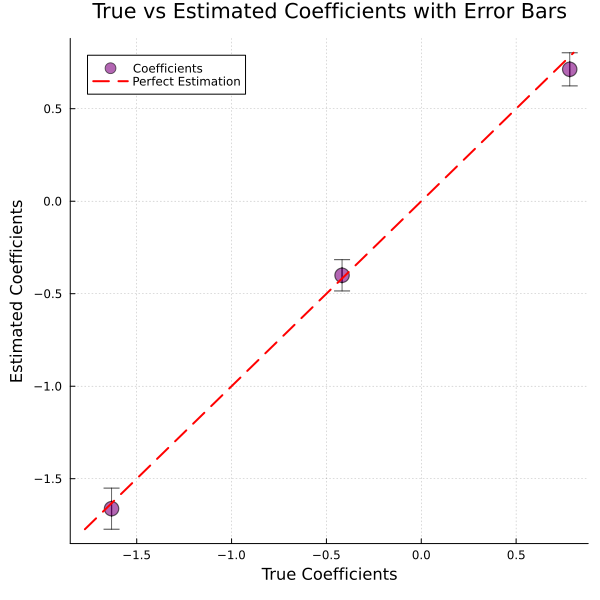

In [ ]:
using Plots
using Printf

# Extract estimated coefficients (excluding intercept)
estimated_coefs = model.coef[2:end]  # Skip intercept
n_coefs = length(estimated_coefs)

# Extract standard errors (excluding intercept)
coef_std = model.std_err[2:end]  # Skip intercept std error

# Calculate 95% confidence intervals
ci_lower = estimated_coefs .- 1.96 .* coef_std
ci_upper = estimated_coefs .+ 1.96 .* coef_std

# Create coefficient indices
coef_indices = 1:n_coefs

# Create plot with confidence intervals
p = plot(coef_indices, estimated_coefs, 
         label="Estimated Coefficients",
         marker=:circle, 
         markersize=6,
         linewidth=2,
         color=:blue,
         xlabel="Coefficient Index",
         ylabel="Coefficient Value",
         title="True vs Estimated Coefficients with 95% CI",
         legend=:best,
         size=(800, 500))

# Add confidence interval ribbons
plot!(p, coef_indices, estimated_coefs,
      ribbon=(estimated_coefs .- ci_lower, ci_upper .- estimated_coefs),
      fillalpha=0.3,
      fillcolor=:blue,
      label="95% CI",
      linewidth=0)

# Add true coefficients
plot!(p, coef_indices, true_coeffs,
      label="True Coefficients",
      marker=:square,
      markersize=6,
      linewidth=2,
      color=:red,
      linestyle=:dash)

# Add a horizontal line at y=0 for reference
hline!(p, [0], color=:gray, linestyle=:dot, label="", linewidth=1)

# Add grid for better readability
plot!(p, grid=true, gridstyle=:dot, gridalpha=0.3)

display(p)

# Print comparison statistics
println("\n" * "="^80)
println("Coefficient Comparison Summary")
println("="^80)
println("Index | True Coef | Estimated | Std Error | 95% CI Lower | 95% CI Upper | Diff | Rel. Error %")
println("-"^80)
for i in 1:n_coefs
    diff = estimated_coefs[i] - true_coeffs[i]
    rel_error = abs(diff / true_coeffs[i]) * 100
    @printf("%5d | %9.4f | %9.4f | %9.4f | %12.4f | %12.4f | %+8.4f | %8.2f%%\n",
            i, true_coeffs[i], estimated_coefs[i], coef_std[i], 
            ci_lower[i], ci_upper[i], diff, rel_error)
end
println("="^80)

# Calculate coverage: how many true coefficients fall within CI
coverage = sum((true_coeffs .>= ci_lower) .& (true_coeffs .<= ci_upper))
coverage_rate = coverage / n_coefs * 100
println("\nConfidence Interval Coverage:")
println("  $(coverage) out of $(n_coefs) true coefficients within 95% CI ($(round(coverage_rate, digits=1))%)")

# Calculate overall metrics
mse = mean((estimated_coefs .- true_coeffs).^2)
mae = mean(abs.(estimated_coefs .- true_coeffs))
correlation = cor(true_coeffs, estimated_coefs)

println("\nOverall Performance Metrics:")
println("  Mean Squared Error (MSE):  ", round(mse, digits=6))
println("  Mean Absolute Error (MAE): ", round(mae, digits=6))
println("  Correlation:               ", round(correlation, digits=6))
println("="^80)

# Create a scatter plot comparing true vs estimated with error bars
p2 = scatter(true_coeffs, estimated_coefs,
             xlabel="True Coefficients",
             ylabel="Estimated Coefficients",
             title="True vs Estimated Coefficients with Error Bars",
             label="Coefficients",
             marker=:circle,
             markersize=8,
             color=:purple,
             alpha=0.6,
             size=(600, 600),
             xerror=zeros(n_coefs),  # No error on true values
             yerror=1.96 .* coef_std)  # 95% CI on estimates

# Add diagonal line (perfect estimation)
coef_range = [minimum([true_coeffs; estimated_coefs; ci_lower]), 
              maximum([true_coeffs; estimated_coefs; ci_upper])]
plot!(p2, coef_range, coef_range,
      label="Perfect Estimation",
      color=:red,
      linestyle=:dash,
      linewidth=2)

plot!(p2, grid=true, gridstyle=:dot, gridalpha=0.3)
display(p2)